# Package loading and basic configurations

In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import pandas as pd
import geopandas as gpd
import numpy as np

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig, TimeSelector

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

# Querying enviroCar Tracks

The following cell queries tracks from the enviroCar API. It defines a bbox for the area of Münster (Germany) and requests 50 tracks. The result is a GeoDataFrame, which is a geo-extended Pandas dataframe from the GeoPandas library. It contains all information of the track in a flat dataframe format including a specific geometry column. 

In [2]:
bbox = BboxSelector([
    7.60000, # min_x
    51.9500, # min_y
    7.64800, # max_x
    51.97300  # max_y
])

# issue a query
track_df = track_api.get_tracks(bbox=bbox, num_results=20) # requesting 20 tracks inside the bbox
track_df

,id,time,geometry,GPS PDOP.value,GPS PDOP.unit,Speed.value,Speed.unit,GPS Altitude.value,GPS Altitude.unit,GPS Bearing.value,...,Consumption.value,Consumption.unit,track.appVersion,track.touVersion,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,MAF.value,MAF.unit,O2 Lambda Voltage.value,O2 Lambda Voltage.unit
0,5e8b930965b80c5d6b4d7cd1,2020-03-07T12:33:15,POINT (7.64069 51.95733),1.090631,precision,28.999999,km/h,110.381939,m,124.858622,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5e8b930965b80c5d6b4d7cd3,2020-03-07T12:33:20,POINT (7.64118 51.95712),1.000000,precision,28.000000,km/h,108.260375,m,125.020801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5e8b930965b80c5d6b4d7cd4,2020-03-07T12:33:26,POINT (7.64162 51.95690),1.257198,precision,28.000001,km/h,105.826028,m,121.203960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5e8b930965b80c5d6b4d7cd5,2020-03-07T12:33:31,POINT (7.64210 51.95672),1.000000,precision,30.000000,km/h,104.395998,m,123.412759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5e8b930965b80c5d6b4d7cd6,2020-03-07T12:33:36,POINT (7.64264 51.95650),1.026727,precision,31.409419,km/h,101.516865,m,122.170479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,5de79e3883df6d628235f6cb,2019-12-04T06:40:14,POINT (7.60258 51.96919),NaN,NaN,0.000000,km/h,107.687455,m,224.190889,...,NaN,NaN,NaN,NaN,1.999969,ratio,9.928095,l/s,0.732361,V
142,5de79e3883df6d628235f6cc,2019-12-04T06:40:19,POINT (7.60253 51.96917),NaN,NaN,15.503841,km/h,107.607230,m,233.359496,...,NaN,NaN,NaN,NaN,1.682820,ratio,69.666618,l/s,0.458675,V
143,5de79e3883df6d628235f6cd,2019-12-04T06:40:24,POINT (7.60192 51.96912),NaN,NaN,43.862375,km/h,106.214225,m,283.664385,...,NaN,NaN,NaN,NaN,1.454498,ratio,81.895074,l/s,0.341717,V
144,5de79e3883df6d628235f6ce,2019-12-04T06:40:30,POINT (7.60088 51.96930),NaN,NaN,54.999998,km/h,106.318071,m,287.260781,...,NaN,NaN,NaN,NaN,1.707472,ratio,28.469685,l/s,0.469096,V


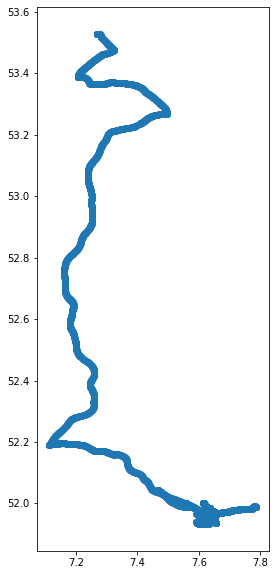

In [3]:
track_df.plot(figsize=(8, 10))

# Inspecting a single Track

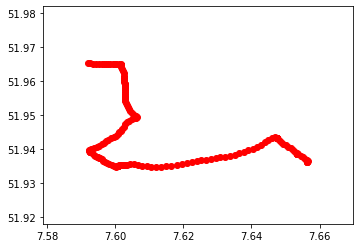

In [4]:
some_track_id = track_df['track.id'].unique()[2]
some_track = track_df[track_df['track.id'] == some_track_id]
some_track.plot(color='red')

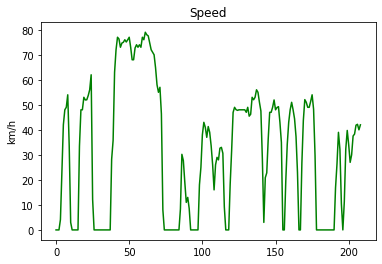

In [5]:
ax = some_track['Speed.value'].plot(color='green')
ax.set_title("Speed")
ax.set_ylabel(some_track['Speed.unit'][0])
ax

# Plot histogram for fuel consumption value 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BB93E97978>]],
      dtype=object)

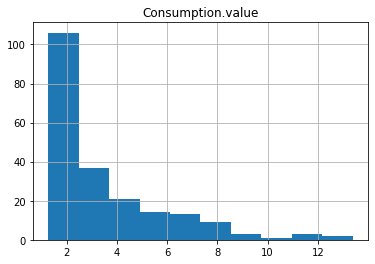

In [6]:
some_track.hist(column='Consumption.value')

## Interactive Map
The following map-based visualization makes use of folium. It allows to visualizate geospatial data based on an interactive leaflet map. Since the data in the GeoDataframe is modelled as a set of Point instead of a LineString, we have to manually create a polyline

In [7]:
import folium

lats = list(some_track['geometry'].apply(lambda coord: coord.y))
lngs = list(some_track['geometry'].apply(lambda coord: coord.x))

avg_lat = sum(lats) / len(lats)
avg_lngs = sum(lngs) / len(lngs)

m = folium.Map(location=[avg_lat, avg_lngs], tiles="Stamen Toner",zoom_start=12)
folium.PolyLine([coords for coords in zip(lats, lngs)], color='red').add_to(m)
m

# Example: Visualization with pydeck (deck.gl)

The pydeck library makes use of the basemap tiles from Mapbox. In case you want to visualize the map with basemap tiles, you need to register with MapBox, and configure a specific access token. The service is free until a certain level of traffic is esceeded.

You can either configure it via your terminal (i.e. `export MAPBOX_API_KEY=<mapbox-key-here>`), which pydeck will automatically read, or you can pass it as a variable to the generation of pydeck (i.e. `pdk.Deck(mapbox_key=<mapbox-key-here>, ...)`.

In [8]:
import pydeck as pdk

# for pydeck the attributes have to be flat
track_df['lat'] = track_df['geometry'].apply(lambda coord: coord.y)
track_df['lng'] = track_df['geometry'].apply(lambda coord: coord.x)
vis_df = pd.DataFrame(track_df)
vis_df['speed'] = vis_df['Speed.value']

# omit unit columns
vis_df_cols = [col for col in vis_df.columns if col.lower()[len(col)-4:len(col)] != 'unit']
vis_df = vis_df[vis_df_cols]

layer = pdk.Layer(
    'ScatterplotLayer',
    data=vis_df,
    get_position='[lng, lat]',
    auto_highlight=True,
    get_radius=10,          # Radius is given in meters
    get_fill_color='[speed < 20 ? 0 : (speed - 20)*8.5, speed < 50 ? 255 : 255 - (speed-50)*8.5, 0, 140]',  # Set an RGBA value for fill
    pickable=True
)

# Set the viewport location
view_state = pdk.ViewState(
    longitude=7.5963592529296875,
    latitude=51.96246168188569,
    zoom=10,
    min_zoom=5,
    max_zoom=15,
    pitch=40.5,
    bearing=-27.36)

r = pdk.Deck(
    width=200, 
    layers=[layer], 
    initial_view_state=view_state , mapbox_key='pk.eyJ1Ijoic2lnZGVsZyIsImEiOiJjazh3dHk2YnQwMGFtM2tuNWtieDN2cmUzIn0.n8h9TtiewMdFuEJPO_q8Rg'
)
r.to_html('tracks_muenster.html', iframe_width=900)

'C:\\Users\\DELL\\Documents\\GitHub\\envirocar-py\\examples\\tracks_muenster.html'